# 多GPU训练
:label:`sec_multi_gpu`

到目前为止，我们讨论了如何在CPU和GPU上高效地训练模型，同时在 :numref:`sec_auto_para`中展示了深度学习框架如何在CPU和GPU之间自动地并行化计算和通信，还在 :numref:`sec_use_gpu`中展示了如何使用`nvidia-smi`命令列出计算机上所有可用的GPU。
但是我们没有讨论如何真正实现深度学习训练的并行化。
是否一种方法，以某种方式分割数据到多个设备上，并使其能够正常工作呢？
本节将详细介绍如何从零开始并行地训练网络，
这里需要运用小批量随机梯度下降算法（详见 :numref:`sec_minibatch_sgd`）。
后面我还讲介绍如何使用高级API并行训练网络（请参阅 :numref:`sec_multi_gpu_concise`）。


## 问题拆分

我们从一个简单的计算机视觉问题和一个稍稍过时的网络开始。
这个网络有多个卷积层和汇聚层，最后可能有几个全连接的层，看起来非常类似于LeNet :cite:`LeCun.Bottou.Bengio.ea.1998`或AlexNet :cite:`Krizhevsky.Sutskever.Hinton.2012`。
假设我们有多个GPU（如果是桌面服务器则有$2$个，AWS g4dn.12xlarge上有$4$个，p3.16xlarge上有$8$个，p2.16xlarge上有$16$个）。
我们希望以一种方式对训练进行拆分，为实现良好的加速比，还能同时受益于简单且可重复的设计选择。
毕竟，多个GPU同时增加了内存和计算能力。
简而言之，对于需要分类的小批量训练数据，我们有以下选择。

第一种方法，在多个GPU之间拆分网络。
也就是说，每个GPU将流入特定层的数据作为输入，跨多个后续层对数据进行处理，然后将数据发送到下一个GPU。
与单个GPU所能处理的数据相比，我们可以用更大的网络处理数据。
此外，每个GPU占用的*显存*（memory footprint）可以得到很好的控制，虽然它只是整个网络显存的一小部分。

然而，GPU的接口之间需要的密集同步可能是很难办的，特别是层之间计算的工作负载不能正确匹配的时候，
还有层之间的接口需要大量的数据传输的时候（例如：激活值和梯度，数据量可能会超出GPU总线的带宽）。
此外，计算密集型操作的顺序对于拆分来说也是非常重要的，这方面的最好研究可参见 :cite:`Mirhoseini.Pham.Le.ea.2017`，其本质仍然是一个困难的问题，目前还不清楚研究是否能在特定问题上实现良好的线性缩放。
综上所述，除非存框架或操作系统本身支持将多个GPU连接在一起，否则不建议这种方法。

第二种方法，拆分层内的工作。
例如，将问题分散到$4$个GPU，每个GPU生成$16$个通道的数据，而不是在单个GPU上计算$64$个通道。
对于全连接的层，同样可以拆分输出单元的数量。
 :numref:`fig_alexnet_original`描述了这种设计，其策略用于处理显存非常小（当时为2GB）的GPU。
当通道或单元的数量不太小时，使计算性能有良好的提升。
此外，由于可用的显存呈线性扩展，多个GPU能够处理不断变大的网络。

![由于GPU显存有限，原有AlexNet设计中的模型并行](../img/alexnet-original.svg)
:label:`fig_alexnet_original`

然而，我们需要大量的同步或*屏障操作*（barrier operation），因为每一层都依赖于所有其他层的结果。
此外，需要传输的数据量也可能比跨GPU拆分层时还要大。
因此，基于带宽的成本和复杂性，我们同样不推荐这种方法。

最后一种方法，跨多个GPU对数据进行拆分。
这种方式下，所有GPU尽管有不同的观测结果，但是执行着相同类型的工作。
在完成每个小批量数据的训练之后，梯度在GPU上聚合。
这种方法最简单，并可以应用于任何情况，同步只需要在每个小批量数据处理之后进行。
也就是说，当其他梯度参数仍在计算时，完成计算的梯度参数就可以开始交换。
而且，GPU的数量越多，小批量包含的数据量就越大，从而就能提高训练效率。
但是，添加更多的GPU并不能让我们训练更大的模型。

![在多个GPU上并行化。从左到右：原始问题、网络并行、分层并行、数据并行](../img/splitting.svg)
:label:`fig_splitting`

 :numref:`fig_splitting`中比较了多个GPU上不同的并行方式。
总体而言，只要GPU的显存足够大，数据并行是最方便的。
有关分布式训练分区的详细描述，请参见 :cite:`Li.Andersen.Park.ea.2014`。
在深度学习的早期，GPU的显存曾经是一个棘手的问题，然而如今除了非常特殊的情况，这个问题已经解决。
下面我们将重点讨论数据并行性。

## 数据并行性

假设一台机器有$k$个GPU。
给定需要训练的模型，虽然每个GPU上的参数值都是相同且同步的，但是每个GPU都将独立地维护一组完整的模型参数。
例如， :numref:`fig_data_parallel`演示了在$k=2$时基于数据并行方法训练模型。

![利用两个GPU上的数据，并行计算小批量随机梯度下降](../img/data-parallel.svg)
:label:`fig_data_parallel`

一般来说，$k$个GPU并行训练过程如下：

* 在任何一次训练迭代中，给定的随机的小批量样本都将被分成$k$个部分，并均匀地分配到GPU上。
* 每个GPU根据分配给它的小批量子集，计算模型参数的损失和梯度。
* 将$k$个GPU中的局部梯度聚合，以获得当前小批量的随机梯度。
* 聚合梯度被重新分发到每个GPU中。
* 每个GPU使用这个小批量随机梯度，来更新它所维护的完整的模型参数集。


在实践中请注意，当在$k$个GPU上训练时，飞桨中不需要改变批量的大小为$k$的倍数（batch_size值保持不变），就像只在单个GPU上训练一样。但是要相应的提高学习率的，提高到$k$数倍。

还请注意， :numref:`sec_batch_norm`中的批量规范化也需要调整，例如，为每个GPU保留单独的批量规范化参数。

下面我们将使用一个简单网络来演示多GPU训练。

In [1]:
%matplotlib inline
import paddle
from paddle import nn
from paddle.nn import functional as F
from d2l import paddle as d2l
import warnings

## 简单网络

我们使用 :numref:`sec_lenet`中介绍的（稍加修改的）LeNet，
从零开始定义它，从而详细说明参数交换和同步。

In [2]:
# 初始化模型参数
scale = 0.01
W1 = paddle.randn(shape=[20, 1, 3, 3]) * scale
b1 = paddle.zeros(shape=[20])
W2 = paddle.randn(shape=[50, 20, 5, 5]) * scale
b2 = paddle.zeros(shape=[50])
W3 = paddle.randn(shape=[800, 128]) * scale
b3 = paddle.zeros(shape=[128])
W4 = paddle.randn(shape=[128, 10]) * scale
b4 = paddle.zeros(shape=[10])
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(x=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(x=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(x=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(x=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape([h2.shape[0], -1])
    h3_linear = paddle.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = paddle.mm(h3, params[6]) + params[7]
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

W0221 23:11:22.446847  5788 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0221 23:11:22.451812  5788 device_context.cc:465] device: 0, cuDNN Version: 7.6.


## 数据同步

对于高效的多GPU训练，我们需要两个基本操作。
首先，我们需要[**向多个设备分发参数**]并附加梯度（`get_params`）。
如果没有参数，就不可能在GPU上评估网络。
第二，需要跨多个设备对参数求和，也就是说，需要一个`allreduce`函数。

In [3]:
def get_params(params, device):
    new_params = [paddle.to_tensor(p, place=device) for p in params]
    for p in new_params:
        p.stop_gradient = False
    return new_params

通过将模型参数复制到一个GPU。

In [4]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 权重:', new_params[1])
print('b1 梯度:', new_params[1].grad)

b1 权重: Tensor(shape=[20], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
b1 梯度: None


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/varbase_patch_methods.py:392: UserWarning: 
tensor.grad will return the tensor value of the gradient. This is an incompatible upgrade for tensor.grad API.  It's return type changes from numpy.ndarray in version 2.0 to paddle.Tensor in version 2.1.0.  If you want to get the numpy value of the gradient, you can use :code:`x.grad.numpy()` 
  warnings.warn(warning_msg)


由于还没有进行任何计算，因此权重参数的梯度仍然为零。
假设现在有一个向量分布在多个GPU上，下面的[**`allreduce`函数将所有向量相加，并将结果广播给所有GPU**]。
请注意，我们需要将数据复制到累积结果的设备，才能使函数正常工作。

In [5]:
# 所有向量相加，并将结果广播给所有GPU
def allreduce(data):
    for i in range(1, len(data)):
        data[0] += paddle.to_tensor(data[i], place=data[0].place)
    for i in range(1, len(data)):
        data[i] = paddle.to_tensor(data[0], place=data[i].place) # 不能用data[i][:] ，用了之后会到gpu:0卡。

通过在不同设备上创建具有不同值的向量并聚合它们。

In [6]:
num_gpus = 2
devices = [d2l.try_gpu(i) for i in range(num_gpus)]

data = [paddle.to_tensor(paddle.ones(shape=[1, 2]) * (i + 1), place=devices[i]) for i in range(2)]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1])

allreduce之前：
 Tensor(shape=[1, 2], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [[1., 1.]]) 
 Tensor(shape=[1, 2], dtype=float32, place=CPUPlace, stop_gradient=True,
       [[2., 2.]])
allreduce之后：
 Tensor(shape=[1, 2], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [[3., 3.]]) 
 Tensor(shape=[1, 2], dtype=float32, place=CPUPlace, stop_gradient=True,
       [[3., 3.]])


## 数据分发

我们需要一个简单的工具函数，[**将一个小批量数据均匀地分布在多个GPU上**]。
例如，有两个GPU时，我们希望每个GPU可以复制一半的数据。
因为深度学习框架的内置函数编写代码更方便、更简洁，所以在$4 \times 5$矩阵上使用它进行尝试。

In [7]:
# 定义飞桨分发函数，将数据分块后分发给所有GPU
def paddlescatter(XY, devices): 
    xy = int(XY.shape[0]/len(devices)) # 根据GPU数目计算分块大小
    return [paddle.to_tensor(XY[i*xy:(i+1)*xy], place=device) for i,device in enumerate(devices)]

# 数据分发
data = paddle.arange(20).reshape([4, 5])
split = paddlescatter(data, devices)

print('input :', data)
print('load into', devices)
print('output:', split)

input : Tensor(shape=[4, 5], dtype=int64, place=CUDAPlace(0), stop_gradient=True,
       [[0 , 1 , 2 , 3 , 4 ],
        [5 , 6 , 7 , 8 , 9 ],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [CUDAPlace(0), CPUPlace]
output: [Tensor(shape=[2, 5], dtype=int64, place=CUDAPlace(0), stop_gradient=True,
       [[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]]), Tensor(shape=[2, 5], dtype=int64, place=CPUPlace, stop_gradient=True,
       [[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])]


为了方便以后复用，我们定义了可以同时拆分数据和标签的`split_batch`函数。

In [8]:
#@save
# 将X和y拆分到多个设备上
def split_batch(X, y, devices):
    """将X和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (paddlescatter(X, devices),
            paddlescatter(y, devices))

## 训练

现在我们可以[**在一个小批量上实现多GPU训练**]。
在多个GPU之间同步数据将使用刚才讨论的辅助函数`allreduce`和`split_and_load`。
我们不需要编写任何特定的代码来实现并行性。
因为计算图在小批量内的设备之间没有任何依赖关系，因此它是“自动地”并行执行。

In [9]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with paddle.no_grad():
        for i in range(len(device_params[0])):
            allreduce(
                [device_params[c][i].grad for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for item in range(len(device_params)):
        param = device_params[item]
        device_params[item] = d2l.sgd(param, lr, X.shape[0]) # 在这里，我们使用全尺寸的小批量
    return device_params

现在，我们可以[**定义训练函数**]。
与前几章中略有不同：训练函数需要分配GPU并将所有模型参数复制到所有设备。
显然，每个小批量都是使用`train_batch`函数来处理多个GPU。
我们只在一个GPU上计算模型的精确度，而让其他GPU保持空闲，尽管这是相对低效的，但是使用方便且代码简洁。

In [10]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到num_gpus个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            device_params = train_batch(X, y, device_params, devices, lr)
            paddle.device.cuda.synchronize()
        timer.stop()
        # 在GPU0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
        f'在{str(devices)}')

让我们看看[**在单个GPU上运行**]效果得有多好。
首先使用的批量大小是$256$，学习率是$0.2$。

测试精度：0.84，10.4秒/轮，在[CUDAPlace(0)]


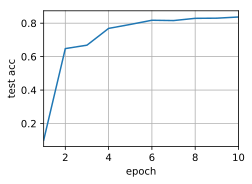

In [11]:
train(num_gpus=1, batch_size=256, lr=0.2)

保持批量大小和学习率不变，并[**增加为2个GPU**]，我们可以看到测试精度与之前的实验基本相同。
不同的GPU个数在算法寻优方面是相同的。
不幸的是，这里没有任何有意义的加速：模型实在太小了；而且数据集也太小了，在这个数据集中，我们实现的多GPU训练的简单方法受到了巨大的Python开销的影响。
在未来，我们将遇到更复杂的模型和更复杂的并行化方法。
尽管如此，让我们看看Fashion-MNIST数据集上会发生什么。

测试精度：0.79，11.6秒/轮，在[CUDAPlace(0), CPUPlace]


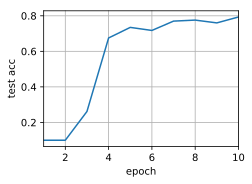

In [12]:
train(num_gpus=2, batch_size=256, lr=0.2)

## 小结

* 有多种方法可以在多个GPU上拆分深度网络的训练。拆分可以在层之间、跨层或跨数据上实现。前两者需要对数据传输过程进行严格编排，而最后一种则是最简单的策略。
* 数据并行训练本身是不复杂的，它通过增加有效的小批量数据量的大小提高了训练效率。
* 在数据并行中，数据需要跨多个GPU拆分，其中每个GPU执行自己的前向传播和反向传播，随后所有的梯度被聚合为一，之后聚合结果向所有的GPU广播。
* 小批量数据量更大时，学习率也需要稍微提高一些。



## 练习

1. 在$k$个GPU上进行训练时，将批量大小从$b$更改为$k \cdot b$，即按GPU的数量进行扩展。
1. 比较不同学习率时模型的精确度，随着GPU数量的增加学习率应该如何扩展？
1. 实现一个更高效的`allreduce`函数用于在不同的GPU上聚合不同的参数？为什么这样的效率更高？
1. 实现模型在多GPU下测试精度的计算。

:begin_tab:`mxnet`
[Discussions](https://discuss.d2l.ai/t/2801)
:end_tab:

:begin_tab:`pytorch`
[Discussions](https://discuss.d2l.ai/t/2800)
:end_tab: